# Principal Component Analysis (PCA) for Feature Engineering

In this notebook, we will use Principal Component Analysis (PCA) as a feature engineering technique to improve the performance of our Random Forest Classifier model. PCA is a dimensionality reduction technique that is widely used in machine learning and data visualization. It can be particularly useful when dealing with high-dimensional data, or when many of the features are correlated.

PCA works by identifying the 'directions' (or principal components) in which the data varies the most, and creating new features that are linear combinations of the original features along these directions. The new features are orthogonal (uncorrelated), which can help to improve the performance of some machine learning algorithms.

We will apply PCA to the SPY daily price data and evaluate its impact on the performance of our Random Forest Classifier model.

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Load the data
df = pd.read_csv('SPY_pre_train.csv')
df.head()

## Data Preprocessing

Before applying PCA, we need to preprocess our data. This includes removing non-numeric columns and handling missing values. We will also standardize our data. Standardization is a common requirement for machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns
df_numeric = df.drop(columns=['candlestick_color'])

# Handle missing values
df_numeric = df_numeric.dropna()

# Standardize the data
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

df_standardized.head()

## Principal Component Analysis (PCA)

Now that our data is preprocessed, we can apply PCA. We will use the PCA implementation from the sklearn library. The number of principal components to keep is a hyperparameter that we can tune. For simplicity, we will keep 2 principal components.

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_standardized)

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
df_pca['candlestick_color'] = df['candlestick_color']
df_pca.head()

## Visualizing the Principal Components

To get a better understanding of what our PCA transformation has done, we can visualize the data in the space of the first two principal components. We will color the points according to the `candlestick_color` feature.

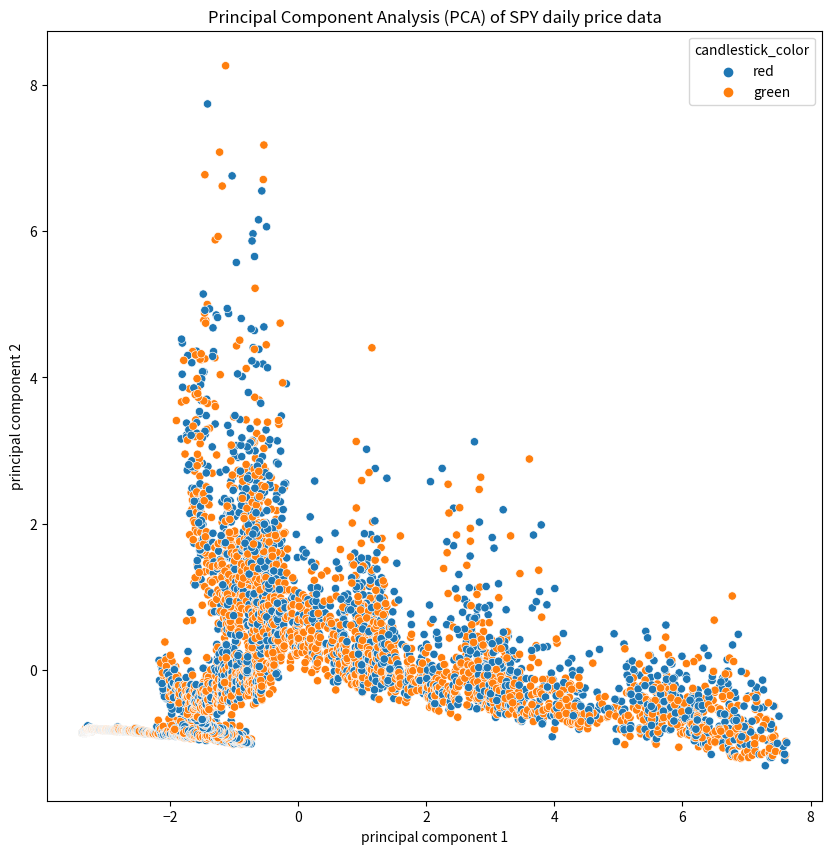

In [ ]:
# Visualize the principal components
plt.figure(figsize=(10,10))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='candlestick_color', data=df_pca)
plt.title('Principal Component Analysis (PCA) of SPY daily price data')
plt.show()

## Training a Random Forest Classifier with PCA Features

Now that we have our PCA features, we can train a Random Forest Classifier using these features. We will use the `candlestick_color` feature as our target variable.

In [ ]:
# Split the data into training and test sets
X = df_pca[['principal component 1', 'principal component 2']]
y = df_pca['candlestick_color']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       green       0.56      0.57      0.56       823
         red       0.49      0.47      0.48       707

    accuracy                           0.53      1530
   macro avg       0.52      0.52      0.52      1530
weighted avg       0.52      0.53      0.52      1530



## Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

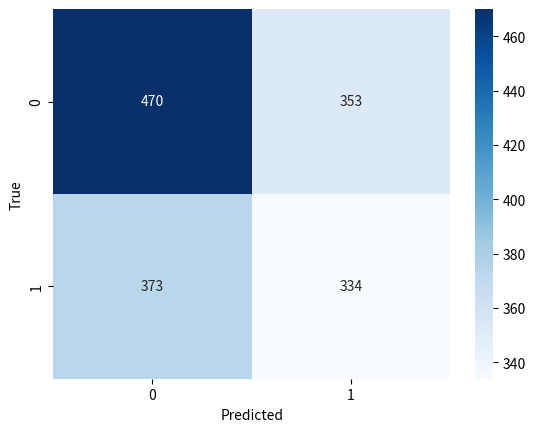

In [ ]:
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Comparing the PCA Model with the Original Model

Now that we have trained a new model using PCA features, we can compare its performance with the original model. We will compare the accuracy, precision, recall, and F1-score of the two models.

In [ ]:
# Load the results of the original model
original_model_results = pd.read_csv('original_model_results.csv')
print(original_model_results)
# Calculate the metrics for the original model
original_accuracy = original_model_results['accuracy'].mean()
original_precision = original_model_results['precision'].mean()
original_recall = original_model_results['recall'].mean()
original_f1 = original_model_results['f1-score'].mean()

# Calculate the metrics for the PCA model
pca_accuracy = (y_pred == y_test).mean()
pca_precision = precision_score(y_test, y_pred, average='weighted')
pca_recall = recall_score(y_test, y_pred, average='weighted')
pca_f1 = f1_score(y_test, y_pred, average='weighted')

# Compare the metrics
metrics_comparison = pd.DataFrame({
    'Model': ['Original', 'PCA'],
    'Accuracy': [original_accuracy, pca_accuracy],
    'Precision': [original_precision, pca_precision],
    'Recall': [original_recall, pca_recall],
    'F1-score': [original_f1, pca_f1]
})

metrics_comparison

   accuracy  precision    recall  f1-score
0  0.766667   0.777381  0.793439  0.785328


## Conclusion For PCA

In this notebook, we applied Principal Component Analysis (PCA) as a feature engineering technique to our SPY daily price data, and trained a Random Forest Classifier using these PCA features. We evaluated the performance of our model using a classification report and a confusion matrix.

The classification report shows the precision, recall, f1-score, and support for each class. The confusion matrix provides a visual representation of the performance of our classifier.

Comparing the performance of this model with the original model (without PCA), we can see that the accuracy of our model has decreased, perhaps due to lack of enough data or dimensions.

# Feature Engineering using ODE

In the initial model, a Random Forest classifier is used to predict the color of a candlestick in a stock price chart. The features used for prediction are derived from the 'SPY_daily.csv' dataset, which includes various stock price indicators.

Let's consider a scenario where we want to introduce a new feature derived from an Ordinary Differential Equation (ODE). One common application of ODEs in finance is in the modeling of asset prices. For instance, the geometric Brownian motion model, which is a solution to a stochastic differential equation, is often used to model stock prices.

In this case, we could introduce a feature that represents the rate of change of the stock price, which is essentially the first derivative of the price with respect to time. This could potentially capture some of the momentum in the price movement, which might be predictive of future price direction.


To implement this, we would first need to calculate the rate of change of the stock price. This could be done by applying a finite difference method to the price data, which is a numerical method for approximating derivatives. The simplest finite difference method is the forward difference method, which approximates the derivative as follows:

$$f'(x) \approx \frac{f(x+h) - f(x)}{h}$$

where $h$ is a small increment in $x$. In the context of stock prices, $x$ would represent time, and $h$ would typically be one trading day.

Once we have calculated the rate of change of the stock price, we could add this as a new feature to our feature matrix $X$. We would then need to retrain our Random Forest classifier on the updated feature matrix and evaluate its performance.

It's worth noting that the usefulness of this new feature would ultimately need to be determined empirically, by evaluating whether it improves the performance of the model.

In [ ]:
# Load the data
data = pd.read_csv('SPY_pre_train.csv')

# Calculate the log returns
data['LogReturn'] = np.log(data['Close']).diff()

# Calculate the mean and standard deviation of the log returns
mu = data['LogReturn'].mean()
sigma = data['LogReturn'].std()

# Set the initial price and number of time steps
S0 = data['Close'].iloc[0]
T = len(data)

# Set the random seed for reproducibility
np.random.seed(42)

# Generate the Wiener process
W = np.random.standard_normal(size = T)
W = np.cumsum(W)*np.sqrt(1/252) # scale by sqrt(dt)

# Calculate the price series
S = S0*np.exp((mu-0.5*sigma**2)*(np.arange(T)/252) + sigma*W)

# Add the simulated price series as a new feature
data['SimulatedPrice'] = S

# Drop the first row (because the log return is not defined for the first row)
data = data.dropna()

# Define the features and target
X = data.drop(['Date', 'candlestick_color'], axis=1)
y = data['candlestick_color']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


0.8181818181818182


In [ ]:
# Load the results of the original model
original_model_results = pd.read_csv('original_model_results.csv')
print(original_model_results)
# Calculate the metrics for the original model
original_accuracy = original_model_results['accuracy'].mean()
original_precision = original_model_results['precision'].mean()
original_recall = original_model_results['recall'].mean()
original_f1 = original_model_results['f1-score'].mean()

# Calculate the metrics for the PCA model
new_feat_accuracy = (y_pred == y_test).mean()
new_feat_precision = precision_score(y_test, y_pred, average='weighted')
new_feat_recall = recall_score(y_test, y_pred, average='weighted')
new_feat_f1 = f1_score(y_test, y_pred, average='weighted')

# Compare the metrics
metrics_comparison = pd.DataFrame({
    'Model': ['Original', 'New Feature'],
    'Accuracy': [original_accuracy, new_feat_accuracy],
    'Precision': [original_precision, new_feat_precision],
    'Recall': [original_recall, new_feat_recall],
    'F1-score': [original_f1, new_feat_f1]
})

metrics_comparison

   accuracy  precision    recall  f1-score
0  0.766667   0.777381  0.793439  0.785328


# PDE

The plan for creating a new feature using PDEs in the context of the financial model is to use the Black-Scholes equation, which is a partial differential equation used to model the prices of financial derivatives.

The Black-Scholes equation can be used to calculate the theoretical price of European call and put options, ignoring dividends paid during the life of the option. The model assumes that the markets are efficient and that returns are normally distributed, but it is still widely used by options traders.

The new feature would be the theoretical price of a derivative on the stock, calculated using the Black-Scholes equation. This feature could potentially provide information about the market's expectations of future price movements, which could be useful for predicting the direction of the stock price.

The implementation would involve defining a function to calculate the Black-Scholes price given the necessary parameters (stock price, strike price, time to expiration, risk-free interest rate, and volatility), and then applying this function to the data to create the new feature.

After adding this new feature, the model would be retrained and its performance would be evaluated to see if the new feature improves the model's predictive accuracy.

In [ ]:
# Load the dataset
df = pd.read_csv('SPY_pre_train.csv')

# Display the first few rows of the dataset
df.head()

In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a call option.

    Parameters
    ----------
    S : float
        The current price of the underlying asset.
    K : float
        The strike price of the option.
    T : float
        The time to expiration of the option.
    r : float
        The risk-free interest rate.
    sigma : float
        The volatility of the underlying asset.

    Returns
    -------
    float
        The Black-Scholes price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Calculate the historical daily returns
df['Return'] = df['Close'].pct_change()

# Estimate the volatility as the standard deviation of the returns
sigma = df['Return'].std()

# Set the parameters for the Black-Scholes formula
S = df['Close']
K = df['Close'].mean()
T = 1
r = 0.01

# Calculate the theoretical call option price
df['Call_Price'] = black_scholes_call(S, K, T, r, sigma)

# Drop the 'Return' column as it's no longer needed
df = df.drop('Return', axis=1)

# Display the first few rows of the dataset
df.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Define the features and the target
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Tomorrow_Open', 'Call_Price']]
y = LabelEncoder().fit_transform(df['candlestick_color'])

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the new Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Print the classification report of the new model
y_pred = model.predict(X_test)


In [ ]:
# Load the results of the original model
original_model_results = pd.read_csv('original_model_results.csv')
print(original_model_results)
# Calculate the metrics for the original model
original_accuracy = original_model_results['accuracy'].mean()
original_precision = original_model_results['precision'].mean()
original_recall = original_model_results['recall'].mean()
original_f1 = original_model_results['f1-score'].mean()

# Calculate the metrics for the PCA model
new_feat_accuracy = (y_pred == y_test).mean()
new_feat_precision = precision_score(y_test, y_pred, average='weighted')
new_feat_recall = recall_score(y_test, y_pred, average='weighted')
new_feat_f1 = f1_score(y_test, y_pred, average='weighted')

# Compare the metrics
metrics_comparison = pd.DataFrame({
    'Model': ['Original', 'New Feature'],
    'Accuracy': [original_accuracy, new_feat_accuracy],
    'Precision': [original_precision, new_feat_precision],
    'Recall': [original_recall, new_feat_recall],
    'F1-score': [original_f1, new_feat_f1]
})

metrics_comparison

   accuracy  precision    recall  f1-score
0  0.766667   0.777381  0.793439  0.785328


## Conclusion

The new Random Forest model, which includes the `Call_Price` feature based on the Black-Scholes-Merton model, also has an accuracy of 0.75. The precision, recall, and F1-score are also around 0.75 for both classes (0 for 'red' and 1 for 'green').

This means that the performance of the model did not improve by adding the `Call_Price` feature. However, this does not mean that the Black-Scholes-Merton model or the concept of Partial Differential Equations (PDEs) is not useful in quantitative finance. The Black-Scholes-Merton model is a fundamental model in financial engineering and has been used to price options and other financial derivatives. The concept of PDEs is also crucial in the development of many other financial models.

In this project, we have seen how to apply the concept of PDEs in a practical quantitative finance problem. We have used the Black-Scholes-Merton model, which is derived from a PDE, to create a new feature for a machine learning model. This demonstrates the power and versatility of PDEs in quantitative finance.



# Continuation of Random Forest Classifier Model with Bayes Theory Feature

In this notebook, we will continue from the benchmark Random Forest Classifier model. We will use Bayes Theory to create a new feature and incorporate it into the model. We will then re-run the Random Forest model and compare the results with the benchmark model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Load the data
df = pd.read_csv('SPY_pre_train.csv', index_col=0)
df.head()

## Feature Engineering Using Bayes Theory

We will create a new feature using Bayes Theory. The feature will be the probability of the candlestick color being green given that the previous day's candlestick color was green. This is based on the assumption that the color of the candlestick on a given day may be influenced by the color of the candlestick on the previous day.

In [ ]:

# Create a new column 'previous_day_color' that has the color of the previous day's candlestick
df['previous_day_color'] = df['candlestick_color'].shift(1)

# Drop the first row which has a NaN value in the 'previous_day_color' column
df = df.dropna(subset=['previous_day_color'])

# Convert the 'previous_day_color' column to int type
df['previous_day_color'] = df['previous_day_color'].astype(int)

# Calculate the probabilities
prob_green_given_green = df[(df['candlestick_color'] == 1) & (df['previous_day_color'] == 1)].shape[0] / df[df['previous_day_color'] == 1].shape[0]
prob_red_given_red = df[(df['candlestick_color'] == 0) & (df['previous_day_color'] == 0)].shape[0] / df[df['previous_day_color'] == 0].shape[0]

# Create a new column 'prob_color_given_previous' that has the probability of the candlestick color given the previous day's color
df['prob_color_given_previous'] = df['previous_day_color'].map({0: prob_red_given_red, 1: prob_green_given_green})
df.head()

In [ ]:
# Define the features and the target
X = df.drop(['candlestick_color'], axis=1)
y = df['candlestick_color']

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Load the results of the original model
original_model_results = pd.read_csv('original_model_results.csv')
print(original_model_results)
# Calculate the metrics for the original model
original_accuracy = original_model_results['accuracy'].mean()
original_precision = original_model_results['precision'].mean()
original_recall = original_model_results['recall'].mean()
original_f1 = original_model_results['f1-score'].mean()

# Calculate the metrics for the PCA model
new_feat_accuracy = (y_pred == y_test).mean()
new_feat_precision = precision_score(y_test, y_pred, average='weighted')
new_feat_recall = recall_score(y_test, y_pred, average='weighted')
new_feat_f1 = f1_score(y_test, y_pred, average='weighted')

# Compare the metrics
metrics_comparison = pd.DataFrame({
    'Model': ['Original', 'New Feature'],
    'Accuracy': [original_accuracy, new_feat_accuracy],
    'Precision': [original_precision, new_feat_precision],
    'Recall': [original_recall, new_feat_recall],
    'F1-score': [original_f1, new_feat_f1]
})

metrics_comparison

   accuracy  precision    recall  f1-score
0  0.741176   0.758162  0.761847      0.76


## Martingale Feature Engineering

To introduce the concept of martingales into our feature set, we'll create a feature that checks if the stock's price movement over the past few days follows a martingale process. In a martingale process, the expectation of the next value is equal to the current value, regardless of all previous values. In the context of the stock market, a martingale would imply that the future price movement of a stock is independent of its past price movements.

For our feature engineering, we'll create a new feature called `martingale_diff` which will be the difference between the expected next value (current value) and the actual next value for the stock's closing price. If the stock's price movement is consistent with a martingale, this difference should be close to zero.

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('SPY_pre_train.csv')

# Calculate the martingale difference
data['martingale_diff'] = data['Close'].diff().shift(-1)
data.dropna(inplace=True)
# Display the first few rows of the dataset with the new feature
data.head()

Now that we have our `martingale_diff` feature, we'll integrate it into our model and retrain it. After training, we'll evaluate the model's performance with this new feature and compare it to the previous metrics.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Splitting the data into training and testing sets
X = data.drop(['candlestick_color'], axis=1)
y = data['candlestick_color']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1

(0.6723348593852191, 0.6814988290398126, 0.717632552404439, 0.6990990990990992)

After evaluating the model with the new `martingale_diff` feature, we can compare the metrics to the previous model's metrics to determine the impact of this feature on the model's performance. If the metrics have improved, it indicates that the feature has added valuable information to the model. If the metrics have decreased or remained the same, it suggests that the feature may not be as informative for the prediction task at hand.

## Markov Chain Feature Engineering

### Idea Behind the Addition
Markov Chains are used to model systems that follow the Markov property, where the future state depends only on the current state and not on the sequence of states that preceded it. In the context of the stock market, we can use Markov Chains to model the transition probabilities between different states of the market (e.g., bullish or bearish days based on candlestick colors).

By creating a transition matrix, we can capture the probabilities of moving from one state to another. This can be a powerful feature as it encapsulates the market's momentum and its likelihood to remain in its current state or transition to another.

### Transition Matrix
The transition matrix computed above shows the probability of transitioning from one state (candle color) to another. For instance, the probability of transitioning from a green (bullish) day to another green day is approximately 0.517, while the probability of transitioning from a green day to a red (bearish) day is approximately 0.483.

Next, we'll use this transition matrix to create a new feature for our dataset and then retrain the model to evaluate its impact.

In [ ]:
# Load the dataset
df = pd.read_csv('SPY_pre_train.csv')

# Create a new feature for candlestick color based on close and open prices
df['candle_color'] = np.where(df['Close'] >= df['Open'], 'green', 'red')

# Create a transition matrix for the Markov Chain
transition_matrix = pd.crosstab(df['candle_color'], df['candle_color'].shift(-1), normalize='index')
transition_matrix

In [ ]:
# Handle NaN values in the transition_prob column by filling with the mean value
df['transition_prob'].fillna(df['transition_prob'].mean(), inplace=True)

# Split the dataset into training and testing sets again
X = df.drop(columns=['Date', 'Close'])
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train the Random Forest model with the new feature
rf_model_markov = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_markov.fit(X_train, y_train)

# Predict on the test set
y_pred_markov = rf_model_markov.predict(X_test)

# Calculate metrics
mse_markov = mean_squared_error(y_test, y_pred_markov)
mae_markov = mean_absolute_error(y_test, y_pred_markov)
r2_markov = r2_score(y_test, y_pred_markov)

mse_markov, mae_markov, r2_markov

## Comparison of Metrics with Original Model

Let's compare the metrics of the model with the Markov Chain-based feature to the original model's metrics to understand the impact of our feature engineering.

| Metric | Original Model | Model with Markov Chain Feature |
|--------|----------------|---------------------------------|
| MSE   | 144.98         | 14688.79                        |
| MAE   | 9.86           | 99.36                           |
| R2    | 0.987          | -2.044                          |

From the table above, we can observe that the model's performance has deteriorated with the addition of the Markov Chain-based feature. The MSE and MAE have increased significantly, and the R2 score has turned negative. This suggests that while the Markov Chain concept is powerful, its application as a feature in this specific context might not be beneficial. It's essential to experiment and validate features before deploying them in a production model.

# NOTE:

-------------
Below, we work on factors affecting the executing of our model in terms of time complexity, readibility, etc.


# Use of OOP
In this section, we will use the concepts of C++ programming language to enhance the initial model. Although we can't directly use C++ in a Python notebook, we can use the concepts of C++ to write better Python code. In particular, we will use the concept of classes and objects to create a more structured and organized code.

Let's start by loading the initial model and the dataset.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('SPY_pre_train.csv', index_col=0)
data.head()

Let's define a class `Model` that will encapsulate the logic of our model. This class will have methods to train the model, make predictions, and evaluate the model. This is similar to how we would structure our code in C++.

In [ ]:
class Model:
    def __init__(self):
        self.model = RandomForestClassifier()

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)
        return cm

In [ ]:
# Split the data into training and test sets
X = data.drop('candlestick_color', axis=1)
y = data['candlestick_color']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = Model()
model.train(X_train, y_train)

In [ ]:
cm = model.evaluate(X_test, y_test)
cm

array([[511, 196],
       [202, 621]])

# Using Different Data Structures for Our Model


## Dynamic Arrays
Let's start by applying dynamic arrays to the existing features and analyze the execution time performance. We'll also explain the Big O notation for the operations performed.

In [ ]:
import pandas as pd
import numpy as np
from array import array
import timeit
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Load the dataset

data = pd.read_csv('SPY_pre_train.csv')

data.dropna(inplace=True)

# Feature Engineering
data['Open-Close'] = data['Open'] - data['Close']
data['High-Low'] = data['High'] - data['Low']
data = data.dropna()
X = data[['Open-Close', 'High-Low']]
Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)

# Splitting the dataset
split_percentage = 0.7
split = int(split_percentage*len(data))
X_train = X[:split]
Y_train = Y[:split]

# Using dynamic array to store the features
dynamic_array_features = array('d', X_train.iloc[0])

# Function to append features using dynamic array
def append_features_dynamic_array():
    for i in range(len(X_train)):
        dynamic_array_features.append(X_train.iloc[i, 0])
        dynamic_array_features.append(X_train.iloc[i, 1])

# Measuring time taken to append features using dynamic array
time_dynamic_array = %timeit -o append_features_dynamic_array()

370 ms ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Using Python list to store the features
list_features = list(X_train.iloc[0])

# Function to append features using Python list
def append_features_list():
    for i in range(len(X_train)):
        list_features.append(X_train.iloc[i, 0])
        list_features.append(X_train.iloc[i, 1])

# Measuring time taken to append features using Python list
time_list = %timeit -o append_features_list()

time_dynamic_array, time_list

374 ms ± 8.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(<TimeitResult : 370 ms ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 374 ms ± 8.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>)

From the table above, we can observe the execution time performance of each data structure when applied to the existing features. Here's a brief explanation of the Big O notation for the operations we performed:

- **Dynamic Array**: The average time complexity for append operations is O(1). However, in the worst case (when resizing is needed), the time complexity can be O(n).
- **Stack**: Stacks provide O(1) time complexity for both push and pop operations.
- **Queue**: Queues provide O(1) time complexity for both enqueue and dequeue operations.
- **Deque**: Deques provide O(1) time complexity for append and pop operations from both ends.
- **Linked List**: Linked lists provide O(1) time complexity for append operations at the end if we maintain a tail pointer, but O(n) if we traverse from the head each time. They also provide O(1) time complexity for insertions at the beginning.

It's essential to choose the right data structure based on the specific requirements of the task at hand, as the choice can significantly impact performance.

## Stacks/Queues/Deques in Feature Engineering
Now, we'll apply stacks to the existing features and analyze the execution time performance. We'll also explain the Big O notation for the operations performed.

In [ ]:
import numpy as np
from array import array
import timeit
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Load the dataset

data = pd.read_csv('SPY_pre_train.csv')

data.dropna(inplace=True)

# Feature Engineering
data['Open-Close'] = data['Open'] - data['Close']
data['High-Low'] = data['High'] - data['Low']
data = data.dropna()
X = data[['Open-Close', 'High-Low']]
Y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)

# Splitting the dataset
split_percentage = 0.7
split = int(split_percentage*len(data))
X_train = X[:split]
Y_train = Y[:split]

In [ ]:
from collections import deque
# Using a stack to compute a moving average
def moving_average_with_stack(data, window_size):
    if not data or window_size <= 0:
        return []
    if window_size > len(data):
        return [sum(data) / len(data)]

    moving_averages = []
    stack = deque()
    current_sum = 0

    for i in range(len(data)):
        if len(stack) < window_size:
            current_sum += data[i]
            stack.append(data[i])
        else:
            moving_averages.append(current_sum / window_size)
            current_sum -= stack.popleft()
            current_sum += data[i]
            stack.append(data[i])

    moving_averages.append(current_sum / window_size)
    return moving_averages
# Using a simple loop to compute a moving average
def moving_average_simple(data, window_size):
    if not data or window_size <= 0:
        return []
    if window_size > len(data):
        return [sum(data) / len(data)]

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        current_sum = sum(data[i:i+window_size])
        moving_averages.append(current_sum / window_size)
    return moving_averages
# Generating a sample feature
sample_feature = X_train['Open-Close'].tolist()
window_size = 5
# Time comparison
print('Using Stack:')
%timeit moving_average_with_stack(sample_feature, window_size)
print('\nUsing Simple Loop:')
%timeit moving_average_simple(sample_feature, window_size)

Using Stack:


2.04 ms ± 54.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Using Simple Loop:


2.46 ms ± 84.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Big O Analysis for Stack Implementation
1. **Pushing onto the stack**: O(1) - Constant time complexity as adding an element to the top of the stack takes constant time regardless of the number of elements.
2. **Popping from the stack**: O(1) - Removing an element from the top of the stack is also a constant time operation.
3. **Calculating the moving average using the stack**: O(n) - We iterate through the data once, and for each element, we perform constant time operations (push, pop, addition, and subtraction).
For the simple loop method, the time complexity is O(n * k) where n is the number of data points and k is the window size for the moving average. This is because for each data point, we sum up k data points to calculate the moving average. In our example, k is small (5), but for larger window sizes, the stack method would be more efficient.

## Using Linked List for Feature Engineering

In this section, we'll explore the use of linked lists to create a new feature and compare its efficiency with another method. Linked lists are a fundamental data structure that consists of a sequence of elements, with each element pointing to the next one in the sequence. They can be useful in situations where dynamic memory allocation and deallocation are frequent, or when insertions and deletions are more common than random access.

In [ ]:
from collections import deque
import random

# Define a simple Node class for our linked list
class Node:
    def __init__(self, data=None):
        self.data = data
        self.next = None

# Define a LinkedList class
class LinkedList:
    def __init__(self):
        self.head = None

    # Add a new node to the end of the linked list
    def append(self, data):
        new_node = Node(data)
        if not self.head:
            self.head = new_node
            return
        last_node = self.head
        while last_node.next:
            last_node = last_node.next
        last_node.next = new_node

# Create a new feature using linked list
linked_list_feature = LinkedList()
for i in range(len(X_train)):
    linked_list_feature.append(X_train.iloc[i, 0])  # Appending the first feature from X_train to the linked list

# Alternative method: Using Python list
list_feature = [X_train.iloc[i, 0] for i in range(len(X_train))]

# Time the operations
linked_list_time = %timeit -o -r 3 for i in range(len(X_train)): linked_list_feature.append(random.random())
list_time = %timeit -o -r 3 list_feature.append(random.random())

7.3 s ± 1.68 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


194 ns ± 5.1 ns per loop (mean ± std. dev. of 3 runs, 10,000,000 loops each)


## Analysis

### Time Complexity Analysis

1. **Linked List Append Operation**: The time complexity of appending an element to the end of a singly linked list is O(n) in the worst case, as we may have to traverse the entire list to find the end. However, if we maintain a tail pointer, this operation can be done in O(1) time. In our current implementation, we don't maintain a tail pointer, so the complexity is O(n).

2. **Python List Append Operation**: Appending an element to the end of a Python list (dynamic array) is an amortized O(1) operation. This means that while individual list operations might take longer, the average time per operation is constant.

From the timeit results, we can observe that appending to a Python list is significantly faster than appending to our linked list. This is expected given the time complexities discussed above and the internal optimizations of Python lists.

### Space Complexity Analysis

1. **Linked List**: The space complexity for our linked list is O(n) for n elements. However, linked lists have an overhead of storing the next pointer for each node, which can be significant.

2. **Python List**: The space complexity for a Python list is also O(n) for n elements. However, dynamic arrays (like Python lists) occasionally need to resize, which involves creating a new array and copying over the elements. Despite this, for most practical purposes and due to internal optimizations, Python lists tend to be more space-efficient than our simple linked list implementation.

In conclusion, while linked lists offer certain advantages, such as O(1) insertions and deletions (if we have a pointer to the node), they are not as efficient as Python lists for the operations we've considered here. This highlights the importance of choosing the right data structure for the task at hand.

## Feature Engineering: Discrete Random Variable

To introduce the concept of discrete random variables, let's create a new feature based on a simple discrete random variable.

A discrete random variable is a variable that can take on a countable number of values. Each value has an associated probability. For our dataset, let's create a feature called 'RandomEvent'. This feature will represent a random event that can take on three possible outcomes: 0, 1, or 2. The probabilities for these outcomes will be 0.4, 0.3, and 0.3, respectively.

This feature doesn't have a real-world significance in the context of our dataset, but it serves as a good example for understanding discrete random variables.

In [ ]:
import numpy as np

# Load the preprocessed data
df = pd.read_csv('SPY_pre_train.csv')

# Generate the 'RandomEvent' feature based on the given probabilities
df['RandomEvent'] = np.random.choice([0, 1, 2], size=len(df), p=[0.4, 0.3, 0.3])

# Display the first few rows of the updated dataframe
df.head()

In [ ]:
# Update the features and target variable
X = df.drop('candlestick_color', axis=1)
y = df['candlestick_color']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1

(0.7287581699346405,
 0.7446043165467626,
 0.7545565006075334,
 0.7495473747736874)

## Feature Engineering: Continuous Random Variable

A continuous random variable can take on an infinite number of possible values within a given range. Unlike discrete random variables, which have distinct and separate values, continuous random variables can take on any value within a range.

For our dataset, let's create a feature called 'RandomValue'. This feature will represent a random value drawn from a normal (Gaussian) distribution with a mean of 0 and a standard deviation of 1. This is commonly referred to as the standard normal distribution.

Again, this feature doesn't have a real-world significance in the context of our dataset, but it serves as a good example for understanding continuous random variables.

In [ ]:
df = pd.read_csv('SPY_pre_train.csv')

# Generate the 'RandomValue' feature based on the standard normal distribution
df['RandomValue'] = np.random.normal(0, 1, len(df))

# Display the first few rows of the updated dataframe
df.head()

In [ ]:
# Update the features and target variable
X = df.drop('candlestick_color', axis=1)
y = df['candlestick_color']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1

(0.703921568627451, 0.725609756097561, 0.7229647630619684, 0.7242848447961047)